# Data description
1. Activity plans
2. Events on the map

In [1]:
%load_ext autoreload
%autoreload 2
%cd D:\sysmo-data
%matplotlib inline

D:\sysmo-data


In [118]:
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import folium
import shapely
from lib import workers as workers

## 1. Activity plans

In [3]:
# Data location
rg = 'palt20'
plans_file = f'dbs/output/plans_{rg}.csv.gz'
df_plans = pd.read_csv(plans_file, compression='gzip')
df_plans.head()

,act_purpose,PId,act_end,act_id,mode,POINT_X,POINT_Y,dep_time,src,score,trav_time,trav_time_min,act_time,distance,speed
0,home,2563148,17:11:36,0,NaN,396957.7460,6.808449e+06,00:00:00,input,0.0,0:00:00,0.000000,851.604949,0.000000,NaN
1,other,2563148,17:53:58,1,car,409693.2538,6.773610e+06,17:11:36,input,0.0,0:34:55,34.919672,7.449304,44.041793,75.673894
2,home,2563148,23:59:59,2,car,396957.7460,6.808449e+06,17:53:58,input,0.0,0:34:55,34.919672,511.106402,43.538279,74.808742
3,home,2563151,11:34:00,0,NaN,407313.5174,6.781791e+06,00:00:00,input,0.0,0:00:00,0.000000,514.001211,0.000000,NaN
4,other,2563151,13:20:56,1,car,406382.8820,6.782691e+06,11:34:00,input,0.0,0:53:09,53.160845,53.779659,10.430200,11.772048


In [4]:
inds = df_plans.PId.unique()

In [5]:
ind = inds[890]
df_plans_ind = df_plans.loc[df_plans.PId==ind, :]
df_plans_ind = df_plans_ind.loc[df_plans_ind.src=='output', :]

### 1.1 Design the visualization

In [46]:
df_tst = pd.DataFrame()
df_tst.loc[:, 'seq'] = range(1, 6)
df_tst.loc[:, 'time'] = [8, 1, 8, 3, 4]
df_tst.loc[:, 'act'] = ['home', 'car', 'work', 'walk', 'home']
df_tst.loc[:, 'PId'] = ind
df_tst.loc[:, 'time_start'] = np.hstack((0,df_tst.loc[:, 'time'].cumsum().values[:-1]))
df_tst.head()

,seq,time,act,PId,time_start
0,1,8,home,2565416,0
1,2,1,car,2565416,8
2,3,8,work,2565416,9
3,4,3,walk,2565416,17
4,5,4,home,2565416,20


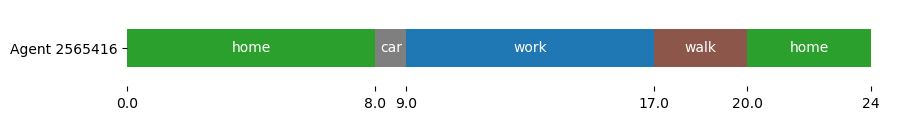

In [114]:
color_dict = {
    'home': 'tab:green',
    'car': 'tab:gray',
    'work': 'tab:blue',
    'walk': 'tab:brown',
    'other': 'tab:orange'
}
# Declaring a figure "gnt"
fig, ax = plt.subplots(figsize=(10, 1))
 
# Setting Y-axis limits
ax.set_xlim(0, 25)
ax.set_ylim(-2, 2)
#sns.scatterplot(df_tst, y='PId', x='time', ax=ax)
ax.broken_barh(list(zip(df_tst.time_start, df_tst.time)), (-1, 2), 
               facecolors =[color_dict[x] for x in df_tst.act])
for x1, x2, act in df_tst[['time_start', 'time', 'act']].values:
    ax.text(x=x1 + x2/2,  
            y=0,
            s=act, 
            ha='center', 
            va='center',
            color='white',
            )
ax.set_xticks([np.floor(x) for x in df_tst.time_start] + [24], 
              labels=[np.floor(x) for x in df_tst.time_start] + [24]) 
ax.set_yticks([0], labels=[f'Agent {ind}']) 
plt.box(on=None)
plt.show()

In [9]:
def plot_activity_plan(df=None, agent_id=None):
    color_dict = {
    'H': 'tab:green',
    'c': 'tab:gray',
    'W': 'tab:blue',
    'w': 'tab:brown',
    'O': 'tab:orange',
    'S': 'tab:purple',
    'b': 'tab:olive',
    'p': 'tab:cyan'
    }
    
    fig, ax = plt.subplots(figsize=(10, 1))
     
    # Setting Y-axis limits
    ax.set_xlim(0, 25)
    ax.set_ylim(-2, 2)
    ax.broken_barh(list(zip(df.time_start, df.time)), (-1, 2), 
                   facecolors =[color_dict[x] for x in df.act])
    for x1, x2, act in df[['time_start', 'time', 'act']].values:
        ax.text(x=x1 + x2/2,  
                y=0,
                s=act, 
                ha='center', 
                va='center',
                color='white',
                )
    ax.set_xticks([np.floor(x) for x in df.time_start] + [24], 
              labels=['%.0f'%np.floor(x) for x in df.time_start] + [24]) 
    ax.set_yticks([0], labels=[f'Agent {agent_id}']) 
    plt.box(on=None)
    plt.show()

### 1.2 Reformat the data

In [8]:
def restructure_plan(df_plan=None):
    act_mapping = {'work': 'W', 'home': 'H', 'other': 'O', 'school': 'S',
                   'car': 'c', 'walk': 'w', 'pt': 'p', 'bike': 'b'}
    df = pd.DataFrame()
    L = len(df_plan)
    df.loc[:, 'seq'] = range(1, L*2)
    df.loc[:, 'time'] = np.stack(df_plan[['trav_time_min', 'act_time']].values, axis=0).reshape(L*2, 1)[1:]
    df.loc[:, 'time_start'] = np.hstack((0, df.loc[:, 'time'].cumsum().values[:-1]))
    df.loc[:, 'time'] /= 60
    df.loc[:, 'time_start'] /= 60
    act_seq = np.stack((df_plan.act_purpose.values[:-1],
                        df_plan['mode'].values[1:]), axis=-1).reshape((L-1)*2, 1)
    act_seq = np.insert(act_seq, len(act_seq), df_plan.act_purpose.values[-1])
    df.loc[:, 'act'] = [act_mapping[x] for x in act_seq]
    return df

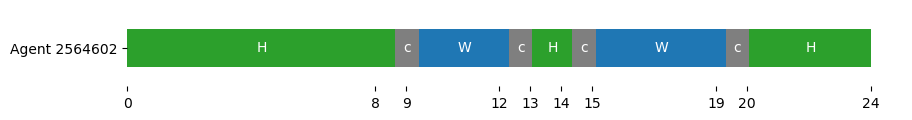

In [154]:
ind = inds[567]
df_plans_ind = df_plans.loc[df_plans.PId==ind, :]
df_plans_ind = df_plans_ind.loc[df_plans_ind.src=='output', :]
plot_activity_plan(df=restructure_plan(df_plan=df_plans_ind), agent_id=ind)

## 2. Agents' activity plans - some examples
### 2.1 Agents with infeasible activity plans (negative utility scores)

In [ ]:
inds_neg = df_plans.loc[df_plans.score < 0, 'PId'].unique()

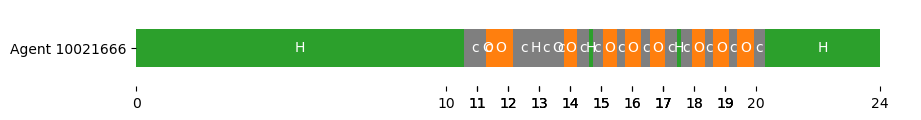

In [157]:
ind = inds_neg[89]
df_plans_ind = df_plans.loc[df_plans.PId==ind, :]
df_plans_ind = df_plans_ind.loc[df_plans_ind.src=='output', :]
plot_activity_plan(df=restructure_plan(df_plan=df_plans_ind), agent_id=ind)

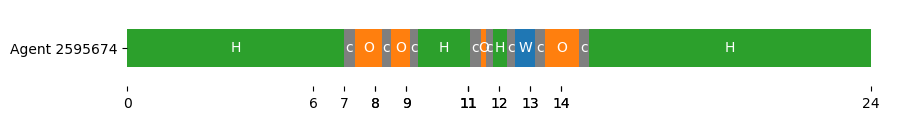

In [158]:
ind = inds_neg[999]
df_plans_ind = df_plans.loc[df_plans.PId==ind, :]
df_plans_ind = df_plans_ind.loc[df_plans_ind.src=='output', :]
plot_activity_plan(df=restructure_plan(df_plan=df_plans_ind), agent_id=ind)

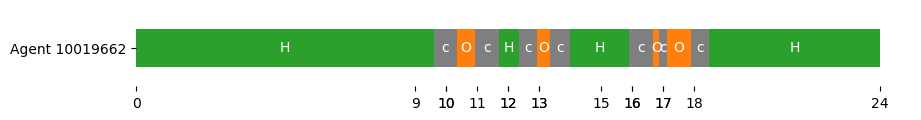

In [161]:
ind = inds_neg[42]
df_plans_ind = df_plans.loc[df_plans.PId==ind, :]
df_plans_ind = df_plans_ind.loc[df_plans_ind.src=='output', :]
plot_activity_plan(df=restructure_plan(df_plan=df_plans_ind), agent_id=ind)

### 2.2 Agents with feasible activity plans

In [11]:
inds_pos = df_plans.loc[df_plans.score > 0, 'PId'].unique()

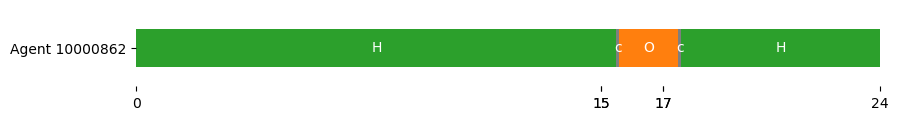

In [163]:
ind = inds_pos[42]
df_plans_ind = df_plans.loc[df_plans.PId==ind, :]
df_plans_ind = df_plans_ind.loc[df_plans_ind.src=='output', :]
plot_activity_plan(df=restructure_plan(df_plan=df_plans_ind), agent_id=ind)

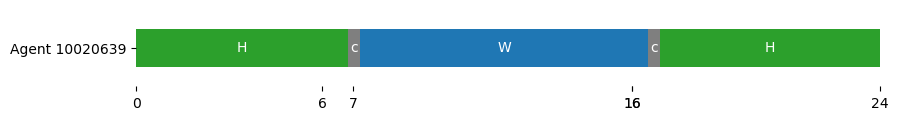

In [165]:
ind = inds_pos[999]
df_plans_ind = df_plans.loc[df_plans.PId==ind, :]
df_plans_ind = df_plans_ind.loc[df_plans_ind.src=='output', :]
plot_activity_plan(df=restructure_plan(df_plan=df_plans_ind), agent_id=ind)

### 2.3 Agents with other modes

Walk

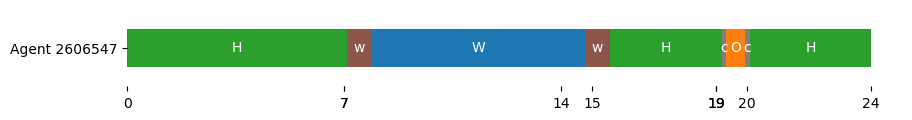

In [181]:
inds_b = df_plans.loc[(df_plans.score > 0) & df_plans['mode'].eq('walk'), 'PId'].unique()
ind = inds_b[89]
df_plans_ind = df_plans.loc[df_plans.PId==ind, :]
df_plans_ind = df_plans_ind.loc[df_plans_ind.src=='output', :]
plot_activity_plan(df=restructure_plan(df_plan=df_plans_ind), agent_id=ind)

Bike

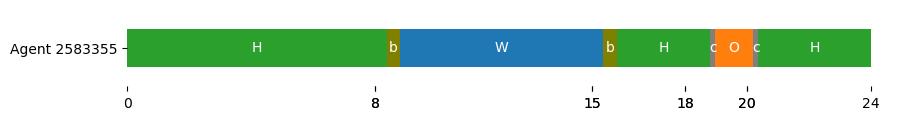

In [183]:
inds_b = df_plans.loc[(df_plans.score > 0) & df_plans['mode'].eq('bike'), 'PId'].unique()
ind = inds_b[42]
df_plans_ind = df_plans.loc[df_plans.PId==ind, :]
df_plans_ind = df_plans_ind.loc[df_plans_ind.src=='output', :]
plot_activity_plan(df=restructure_plan(df_plan=df_plans_ind), agent_id=ind)

Public transit

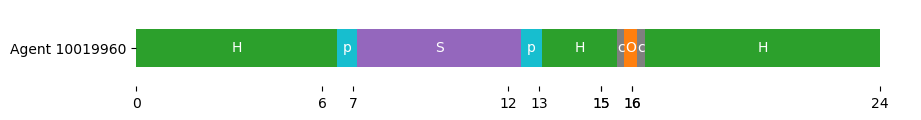

In [187]:
inds_b = df_plans.loc[(df_plans.score > 0) & df_plans['mode'].eq('pt'), 'PId'].unique()
ind = inds_b[1]
df_plans_ind = df_plans.loc[df_plans.PId==ind, :]
df_plans_ind = df_plans_ind.loc[df_plans_ind.src=='output', :]
plot_activity_plan(df=restructure_plan(df_plan=df_plans_ind), agent_id=ind)

## 3. Events

In [6]:
# Data location
rg = 'palt20'
batch = 0
events_file = f'dbs/events/{rg}_events_batch{batch}.csv.gz'
df_events = pd.read_csv(events_file, compression='gzip')
df_events.head()

,time,type,person,link,vehicle,link_id,batch
0,48370.0,actend,10000585,4878076920006f,NaN,7909.0,0
1,48371.0,vehicle enters traffic,10000585,4878076920006f,10000585.0,7909.0,0
2,48372.0,left link,10000585,4878076920006f,10000585.0,7909.0,0
3,48411.0,left link,10000585,363342740022f,10000585.0,8014.0,0
4,48445.0,left link,10000585,363342740024f,10000585.0,7998.0,0


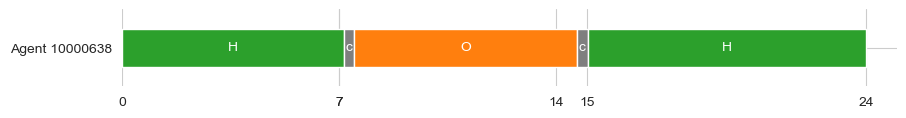

In [12]:
ind = inds_pos[7]
df_plans_ind = df_plans.loc[df_plans.PId==ind, :]
df_plans_ind = df_plans_ind.loc[df_plans_ind.src=='output', :]
plot_activity_plan(df=restructure_plan(df_plan=df_plans_ind), agent_id=ind)

In [13]:
df_events_ind = df_events.loc[df_events.person==ind, :]
df_events_ind.head()

,time,type,person,link,vehicle,link_id,batch
237,25751.0,vehicle enters traffic,10000638,1034541760001f,10000638.0,7820.0,0
238,25751.0,actend,10000638,1034541760001f,NaN,7820.0,0
239,25752.0,left link,10000638,1034541760001f,10000638.0,7820.0,0
240,25757.0,left link,10000638,718913970011r,10000638.0,7823.0,0
241,25813.0,left link,10000638,1034541810008r,10000638.0,7831.0,0


In [14]:
gdf_network = gpd.read_file('dbs/network/network.shp')
gdf_network.head()

,length,freespeed,capacity,permlanes,oneway,link_id,count,geometry
0,226.510087,4.166667,600.0,1.0,1,0,1,"LINESTRING (563992.768 6747623.594, 563953.829..."
1,63.598364,4.166667,600.0,1.0,1,1,1,"LINESTRING (563901.883 6747365.117, 563953.829..."
2,226.510087,4.166667,600.0,1.0,1,2,1,"LINESTRING (563953.829 6747400.496, 563992.768..."
3,63.598364,4.166667,600.0,1.0,1,3,1,"LINESTRING (563953.829 6747400.496, 563901.883..."
4,4048.600079,4.166667,600.0,1.0,1,4,6,"LINESTRING (560161.139 6747107.106, 563901.883..."


In [15]:
gdf_events_ind = pd.merge(df_events_ind, gdf_network[['link_id', 'geometry']], on='link_id', how='left')
gdf_events_ind.head()

,time,type,person,link,vehicle,link_id,batch,geometry
0,25751.0,vehicle enters traffic,10000638,1034541760001f,10000638.0,7820.0,0,"LINESTRING (567006.553 6666431.510, 566909.226..."
1,25751.0,actend,10000638,1034541760001f,NaN,7820.0,0,"LINESTRING (567006.553 6666431.510, 566909.226..."
2,25752.0,left link,10000638,1034541760001f,10000638.0,7820.0,0,"LINESTRING (567006.553 6666431.510, 566909.226..."
3,25757.0,left link,10000638,718913970011r,10000638.0,7823.0,0,"LINESTRING (566909.226 6666242.057, 566900.677..."
4,25813.0,left link,10000638,1034541810008r,10000638.0,7831.0,0,"LINESTRING (566900.677 6666224.490, 567071.203..."


### 3.1 Visualization on the map

In [ ]:
gdf_events_ind = gpd.GeoDataFrame(gdf_events_ind, geometry='geometry').to_crs(4326)
gdf_events_ind['points'] = gdf_events_ind.apply(lambda x: [y for y in x['geometry'].coords], axis=1)

In [46]:
points = []
for x in gdf_events_ind['points'].values:
    points += x
gdf_points = gpd.GeoDataFrame({}, geometry=[shapely.geometry.Point(x[0], x[1]) for x in points])
center = gdf_points.dissolve().centroid
center = [center.y.values[0], center.x.values[0]]

In [54]:
gdf_plans_ind = workers.df2gdf_point(df_plans_ind, x_field='POINT_X', y_field='POINT_Y',
                                     crs=3006, drop=True)
gdf_plans_ind.dropna(inplace=True)
gdf_plans_ind = gdf_plans_ind.to_crs(4326)
gdf_plans_ind.loc[:, 'latitude'] = gdf_plans_ind.geometry.y
gdf_plans_ind.loc[:, 'longitude'] = gdf_plans_ind.geometry.x

In [59]:
color_dict = {
'home': 'green',
'work': 'blue',
'other': 'orange',
'school': 'purple'
}

In [121]:
m = folium.Map(location=center, zoom_start=12)
 
folium.Choropleth(
    gdf_events_ind,
    line_weight=3,
    line_color='steelblue'
).add_to(m)
gdf_plans_ind.apply(lambda row : folium.CircleMarker(
    location=(row["latitude"], row["longitude"]), radius=3, 
    fill_color=color_dict[row['act_purpose']], 
    popup=row['act_purpose'],
    color=color_dict[row['act_purpose']]).add_to(m), axis=1)
m

Define the function to visualize a given agent's visited locations and trajectories along the road.

In [64]:
def events_map(df_events=None, df_plan=None, network=None):
    gdf_events_ind = pd.merge(df_events, network[['link_id', 'geometry']], on='link_id', how='left')
    # Process the data to get centroid
    gdf_events_ind = gpd.GeoDataFrame(gdf_events_ind, geometry='geometry').to_crs(4326)
    gdf_events_ind['points'] = gdf_events_ind.apply(lambda x: [y for y in x['geometry'].coords], axis=1)
    points = []
    for x in gdf_events_ind['points'].values:
        points += x
    gdf_points = gpd.GeoDataFrame({}, geometry=[shapely.geometry.Point(x[0], x[1]) for x in points])
    center = gdf_points.dissolve().centroid
    center = [center.y.values[0], center.x.values[0]]
    # Prepare plans locations
    gdf_plans_ind = workers.df2gdf_point(df_plan, x_field='POINT_X', y_field='POINT_Y',
                                     crs=3006, drop=True)
    gdf_plans_ind.dropna(inplace=True)
    gdf_plans_ind = gdf_plans_ind.to_crs(4326)
    gdf_plans_ind.loc[:, 'latitude'] = gdf_plans_ind.geometry.y
    gdf_plans_ind.loc[:, 'longitude'] = gdf_plans_ind.geometry.x
    
    # Put on the map
    color_dict = {
        'home': 'green',
        'work': 'blue',
        'other': 'orange',
        'school': 'purple'
    }
    m = folium.Map(location=center, zoom_start=12)
 
    folium.Choropleth(
        gdf_events_ind,
        line_weight=3,
        line_color='steelblue'
    ).add_to(m)
    gdf_plans_ind.apply(lambda row : folium.CircleMarker(
        location=(row["latitude"], row["longitude"]), radius=3, 
        fill_color=color_dict[row['act_purpose']], 
        popup=row['act_purpose'],
        color=color_dict[row['act_purpose']]).add_to(m), axis=1)
    return m

## 4. Agents' events and plans - some examples

In [65]:
# Events data location
rg = 'palt20'
batch = 0
events_file = f'dbs/events/{rg}_events_batch{batch}.csv.gz'
df_events = pd.read_csv(events_file, compression='gzip')

# Plans
plans_file = f'dbs/output/plans_{rg}.csv.gz'
df_plans = pd.read_csv(plans_file, compression='gzip')
inds_pos = df_plans.loc[df_plans.score > 0, 'PId'].unique()

# Road network
gdf_network = gpd.read_file('dbs/network/network.shp')

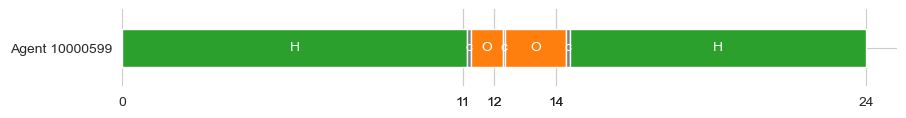

In [95]:
ind = inds_pos[4]
df_plans_ind = df_plans.loc[df_plans.PId==ind, :]
df_plans_ind = df_plans_ind.loc[df_plans_ind.src=='output', :]
df_events_ind = df_events.loc[df_events.person==ind, :]
if len(df_events_ind) > 0:
    plot_activity_plan(df=restructure_plan(df_plan=df_plans_ind), agent_id=ind)

In [96]:
m = events_map(df_events=df_events_ind, df_plan=df_plans_ind, network=gdf_network)
m

### 4.1 Agents with infeasible activity plans (negative utility scores)

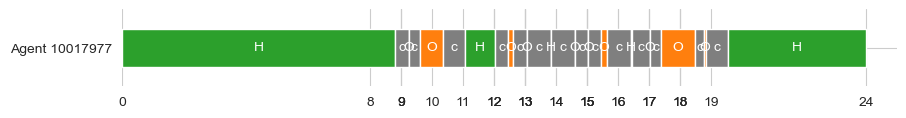

In [98]:
inds_neg = df_plans.loc[df_plans.score < 0, 'PId'].unique()
for i in range(0, len(inds_neg)):
    ind = inds_neg[i]
    df_plans_ind = df_plans.loc[df_plans.PId==ind, :]
    df_plans_ind = df_plans_ind.loc[df_plans_ind.src=='output', :]
    df_events_ind = df_events.loc[df_events.person==ind, :]
    if len(df_events_ind) > 0:
        plot_activity_plan(df=restructure_plan(df_plan=df_plans_ind), agent_id=ind)
        break

In [99]:
m = events_map(df_events=df_events_ind, df_plan=df_plans_ind, network=gdf_network)
m

### 4.2 Agents with feasible activity plans

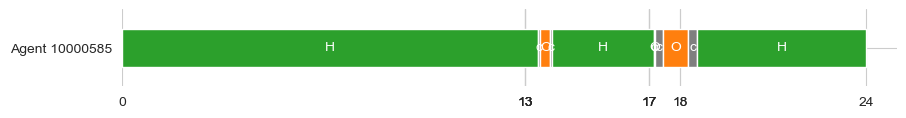

In [100]:
inds_pos = df_plans.loc[df_plans.score > 0, 'PId'].unique()
for i in range(0, len(inds_pos)):
    ind = inds_pos[i]
    df_plans_ind = df_plans.loc[df_plans.PId==ind, :]
    df_plans_ind = df_plans_ind.loc[df_plans_ind.src=='output', :]
    df_events_ind = df_events.loc[df_events.person==ind, :]
    if len(df_events_ind) > 0:
        plot_activity_plan(df=restructure_plan(df_plan=df_plans_ind), agent_id=ind)
        break

In [101]:
m = events_map(df_events=df_events_ind, df_plan=df_plans_ind, network=gdf_network)
m

### 4.3 Agents with other modes
Walk

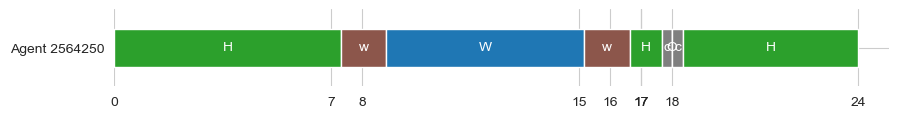

In [105]:
inds_b = df_plans.loc[(df_plans.score > 0) & df_plans['mode'].eq('walk'), 'PId'].unique()
for i in range(4, len(inds_b)):
    ind = inds_b[i]
    df_plans_ind = df_plans.loc[df_plans.PId==ind, :]
    df_plans_ind = df_plans_ind.loc[df_plans_ind.src=='output', :]
    df_events_ind = df_events.loc[df_events.person==ind, :]
    if len(df_events_ind) > 0:
        plot_activity_plan(df=restructure_plan(df_plan=df_plans_ind), agent_id=ind)
        break

In [106]:
m = events_map(df_events=df_events_ind, df_plan=df_plans_ind, network=gdf_network)
m

Bike

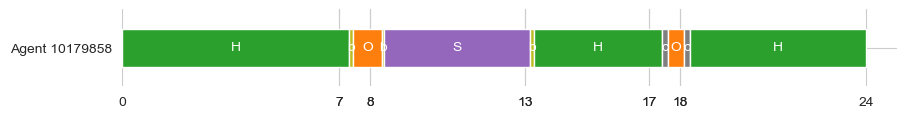

In [108]:
inds_b = df_plans.loc[(df_plans.score > 0) & df_plans['mode'].eq('bike'), 'PId'].unique()
for i in range(5, len(inds_b)):
    ind = inds_b[i]
    df_plans_ind = df_plans.loc[df_plans.PId==ind, :]
    df_plans_ind = df_plans_ind.loc[df_plans_ind.src=='output', :]
    df_events_ind = df_events.loc[df_events.person==ind, :]
    if len(df_events_ind) > 0:
        plot_activity_plan(df=restructure_plan(df_plan=df_plans_ind), agent_id=ind)
        break

In [109]:
m = events_map(df_events=df_events_ind, df_plan=df_plans_ind, network=gdf_network)
m

Public transit

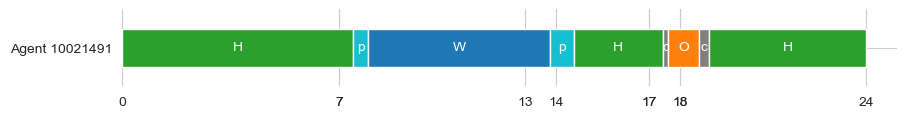

In [110]:
inds_b = df_plans.loc[(df_plans.score > 0) & df_plans['mode'].eq('pt'), 'PId'].unique()
for i in range(0, len(inds_b)):
    ind = inds_b[i]
    df_plans_ind = df_plans.loc[df_plans.PId==ind, :]
    df_plans_ind = df_plans_ind.loc[df_plans_ind.src=='output', :]
    df_events_ind = df_events.loc[df_events.person==ind, :]
    if len(df_events_ind) > 0:
        plot_activity_plan(df=restructure_plan(df_plan=df_plans_ind), agent_id=ind)
        break

In [111]:
m = events_map(df_events=df_events_ind, df_plan=df_plans_ind, network=gdf_network)
m